In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.4 MB/s eta 0:00:00


# New Section

<ipython-input-3-27866f1bd91d>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Reliance.fillna(method='ffill', inplace=True)
<ipython-input-3-27866f1bd91d>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Reliance.fillna(method='bfill', inplace=True)


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.18 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=56735.788, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=54836.881, Time=0.23 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=56733.790, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=54332.764, Time=0.52 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=53911.434, Time=0.72 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=53602.524, Time=0.95 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=53403.613, Time=0.95 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=12.35 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=11.06 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=53401.615, Time=0.52 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=53600.526, Time=0.49 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=7.35 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, 

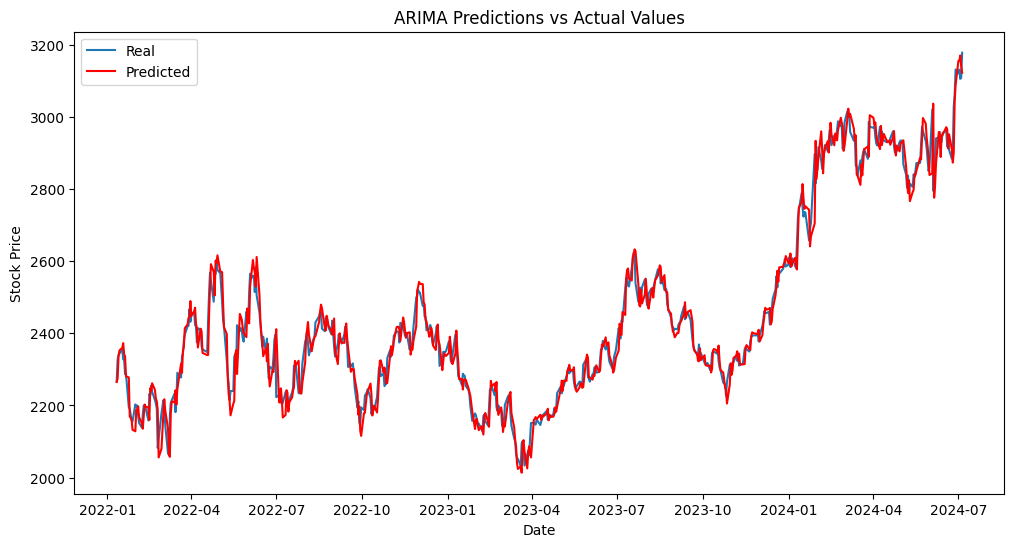

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

Reliance = pd.read_csv('/content/sample_data/RELIANCE.NS.csv', index_col='Date', parse_dates=True)
Reliance.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
Reliance.fillna(method='ffill', inplace=True)
Reliance.fillna(method='bfill', inplace=True)
Reliance['returns'] = Reliance['Close'].diff().div(Reliance.Close).dropna()
Reliance.dropna(inplace=True)
Reliance.head()

model = auto_arima(Reliance['Close'], seasonal=False, trace=True)
order = model.order

seq = Reliance['Close'].values
seq_train = seq[:int(len(seq)*0.9)]
seq_test = seq[int(len(seq)*0.9):]

def arima_forecast(history):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

history = [x for x in seq_train]
predictions = list()
for t in range(len(seq_test)):
    yhat = arima_forecast(history)
    predictions.append(yhat)
    obs = seq_test[t]
    history.append(obs)

size = int(len(seq)*0.9)
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(Reliance['Close'].iloc[size:].index, seq_test, label='Real')
plt.plot(Reliance['Close'].iloc[size:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Epoch 1/3
4840/4840 [==============================] - 198s 39ms/step - loss: 1.5752e-04 - val_loss: 0.0011
Epoch 2/3
4840/4840 [==============================] - 188s 39ms/step - loss: 5.2787e-05 - val_loss: 3.9996e-04
Epoch 3/3
38/38 [==============================] - 2s 16ms/step


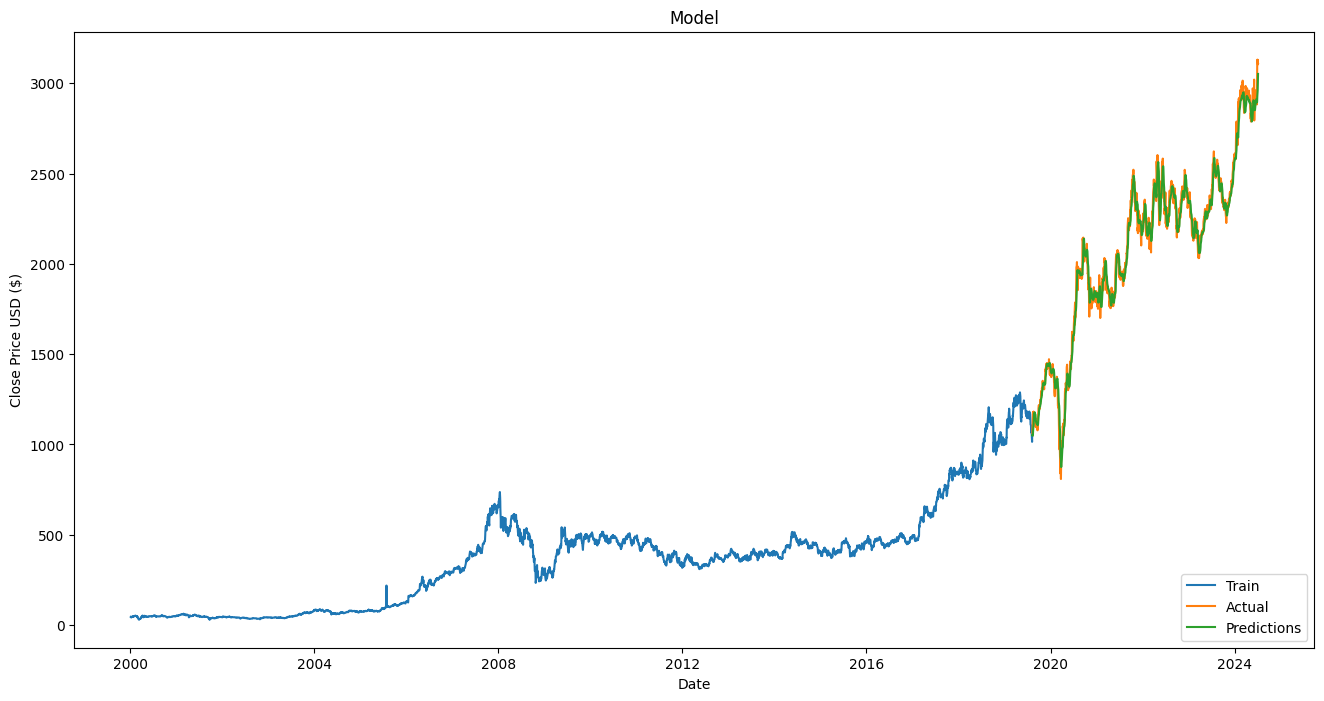

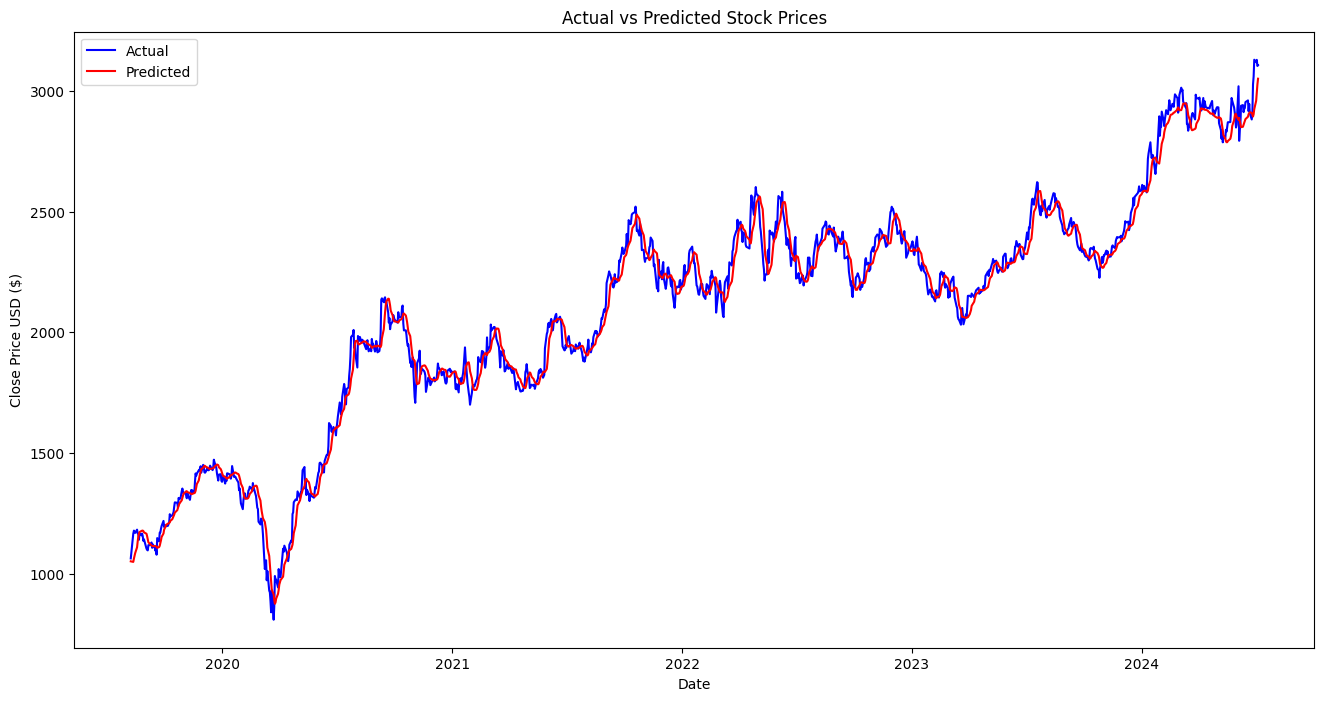

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Load the data
file_path = '/content/RELIANCE.NS.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.dropna()
prices = data['Close'].values
prices = prices.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Create sequences
def create_sequences(data, seq_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon):
        X.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length:i + seq_length + forecast_horizon, 0])
    return np.array(X), np.array(y)

seq_length = 60
forecast_horizon = 1
X, y = create_sequences(scaled_prices, seq_length, forecast_horizon)

# Split the data
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)).astype(np.float32)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)).astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Step 2: Train the Model
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(forecast_horizon))

# Compile the model with a lower learning rate and gradient clipping
optiermizer = Adam(learning_rate=0.0001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_ror')

# Train the model
history = model.fit(X_train, y_train, batch_size=1, epochs=3, validation_data=(X_test, y_test))

# Step 3: Test the Model
# Generate predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Inverse transform the actual values as well
y_test = scaler.inverse_transform(y_test)

# Step 4: Visualize Predictions
# Prepare the data for plotting
train = data[:split + seq_length]
valid = data[split + seq_length:split + seq_length + len(predictions)].copy()
valid['Predictions'] = np.nan

for i in range(len(predictions)):
    valid.iloc[i:i+forecast_horizon, valid.columns.get_loc('Predictions')] = predictions[i]

valid['Actual'] = np.nan
for i in range(len(y_test)):
    valid.iloc[i:i+forecast_horizon, valid.columns.get_loc('Actual')] = y_test[i]

# Plot the results
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'], label='Train')
plt.plot(valid['Close'], label='Actual')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(16, 8))
plt.plot(valid.index, valid['Actual'], color='blue', label='Actual')
plt.plot(valid.index, valid['Predictions'], color='red', label='Predicted')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()

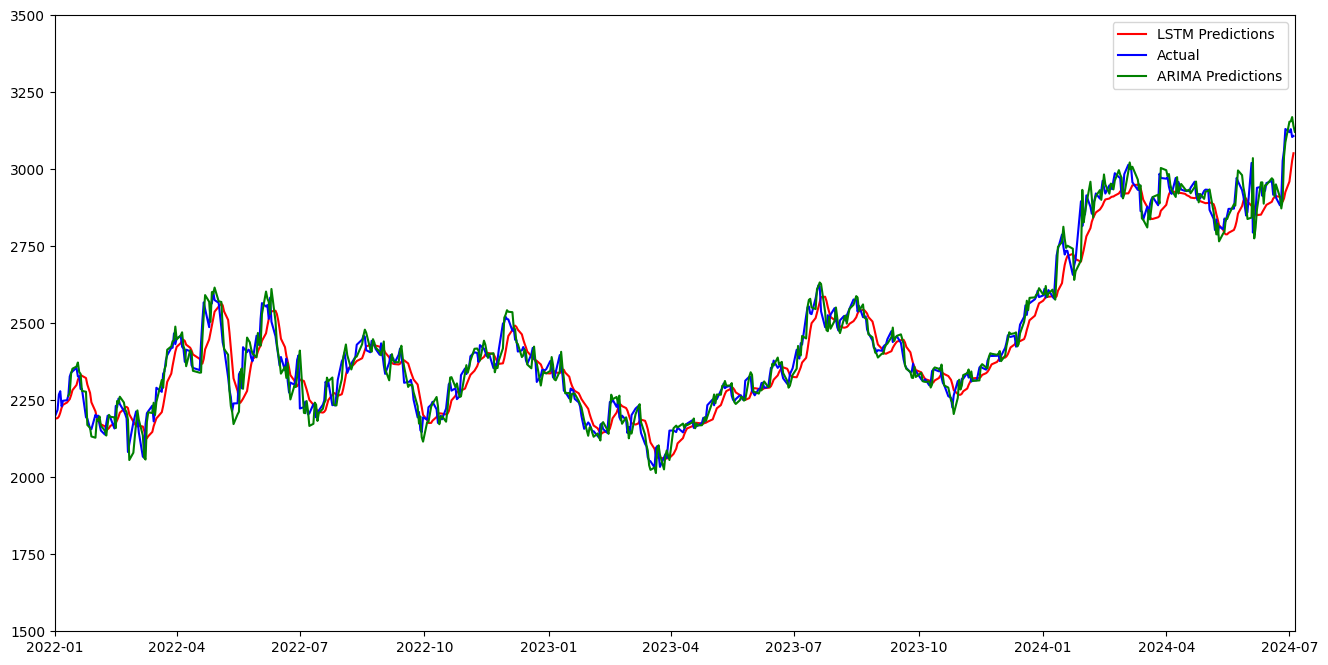

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(valid.index, valid['Predictions'], color='red', label='LSTM Predictions')
plt.plot(valid.index, valid['Actual'], color='blue', label='Actual')
plt.plot(Reliance['Close'].iloc[size:].index, predictions, color='green', label='ARIMA Predictions')

# Set xlim based on datetime strings
plt.xlim(pd.Timestamp('2022-01-01'), pd.Timestamp('2024-07-05'))
plt.ylim(1500, 3500)
plt.legend()
plt.show()
